# **Deep Learning Project: Deep Lesion Scan**

## **Overview**
This notebook demonstrates a comprehensive deep learning pipeline for classifying skin lesion images using the HAM10000 dataset. The project involves data preprocessing, augmentation, model building with a custom attention mechanism, training, and evaluation.

## **Key Components**

#### 1. Data Collection and Preprocessing
- **HAM10000 Metadata**: Loads the metadata, which contains lesion information such as diagnosis, age, sex, and localization.
- **Handling Duplicates**: Marks and handles duplicate lesion entries to ensure accurate data representation.
- **Dataset Split**: Uses stratified sampling to split the data into training (85%) and testing (15%) sets, ensuring class distribution is maintained.
- **Image Organization**: Organizes images into class-specific directories based on 7 lesion types: akiec, bcc, bkl, df, mel, nv, vasc.

#### 2. Data Augmentation
- **Addressing Class Imbalance**: Creates additional training samples by applying augmentation techniques to underrepresented classes.
- **Augmentation Techniques**: Includes rotation, width/height shifting, brightness adjustment, channel shifting, shearing, zooming, and flipping.
- **Augmented Images**: Generates 8,000 augmented images for minority classes (mel, df, akiec, bcc) and 2,000 augmented images for majority classes (bkl, nv, vasc).

#### 3. Model Architecture
- **Base Model**: Utilizes ResNet50 as the base model, pretrained on ImageNet, for feature extraction.
- **Soft Attention Mechanism**: Implements a custom attention layer that uses 3D convolution to generate attention maps and multi-head attention (16 heads) for improved feature selection.
- **Architectural Components**: Adds max-pooling layers, concatenation of attention features, global average pooling, and dense layers with L2 regularization, batch normalization, and dropout for regularization.

#### 4. Training and Fine-Tuning
- **Optimizer and Learning Rate**: Compiles the model with the Adam optimizer (learning rate = 0.0001) and uses label smoothing in the loss function to improve training stability.
- **Model Compilation**: The model is compiled with accuracy as the evaluation metric.
- **Training Settings**: Uses a batch size of 32 with automatic training-validation split (75-25%) and applies ResNet50’s standard image preprocessing.

#### 5. Evaluation
- **Test Set Evaluation**: The model is evaluated on a separate test set to assess its generalization ability.
- **Classification Metrics**: Generates key metrics, including precision, recall, accuracy, confusion matrix, ROC curves, and AUC scores.
- **Comprehensive Evaluation**: Utilizes sklearn metrics to provide detailed performance insights and evaluation.

#### 6. Visualization
- **Training Curves**: Uses matplotlib to plot training loss and accuracy curves over epochs for performance monitoring.
- **Attention Maps**: Visualizes the attention maps to understand the areas of focus in the images during classification.
- **Performance Metrics**: Provides clear visual outputs for confusion matrices, ROC curves, and AUC scores for model performance analysis.

This project demonstrates a complete pipeline from raw data preprocessing to model evaluation, with a focus on handling class imbalance and utilizing attention mechanisms for improved skin lesion classification.


### **Importing Important Libraries**

We import all necessary libraries for handling data, building and training neural networks, and evaluating model performance.

- **pandas, numpy, os**: For data manipulation and file handling.
- **cv2 (OpenCV)**: For image processing tasks.
- **tensorflow, keras**: Core deep learning libraries for model creation, training, and deployment.
- **glob, shutil**: For managing file paths and directories.
- **matplotlib.pyplot**: For data visualization and plotting training metrics.
- **scikit-learn (sklearn)**: For splitting data and computing evaluation metrics such as precision, recall, and confusion matrix.
- **PIL (Python Imaging Library)**: For robust image loading and handling truncated images safely.
- **Callbacks (ModelCheckpoint, EarlyStopping)**: For monitoring and saving model checkpoints during training.


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
get_ipython().run_line_magic('matplotlib', 'inline')
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


2025-04-18 21:18:54.836361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745011135.095762      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745011135.159797      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Loading Dataset from Directory**

We define the path to the dataset directory (in this case, located in a Kaggle environment) and list all files and folders to verify the contents of the dataset.


In [ ]:
dataset_path = "/kaggle/input/"
print(os.listdir(dataset_path))  # List files and folders inside

['dataverse_files']


###**Loading Metadata**

We load the **HAM10000 metadata CSV file** into a pandas DataFrame. This metadata includes important information about each skin lesion image, such as diagnosis labels, patient age, and localization.


In [ ]:
data_pd= "/kaggle/input/dataverse_files/HAM10000_metadata"
# Load the CSV file into a pandas DataFrame
data_pd = pd.read_csv(data_pd)

# Display the first few rows
print(data_pd.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  


###**Defining Train and Test Directories**

We define the paths for the **training** and **testing** datasets, which are organized in separate directories. These directories will be used for loading images for model training and evaluation.


In [ ]:
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

### **Grouping Data by Lesion ID**

We group the metadata by **'lesion_id'** to count the occurrences of each unique lesion. This helps to understand the distribution of images for each skin lesion type in the dataset.


In [ ]:
# Group by 'lesion_id' and count occurrences
df_count = data_pd.groupby('lesion_id').count()

# Display the first few rows of grouped data
print(df_count.head())

             image_id  dx  dx_type  age  sex  localization  dataset
lesion_id                                                          
HAM_0000000         2   2        2    2    2             2        2
HAM_0000001         1   1        1    1    1             1        1
HAM_0000002         3   3        3    3    3             3        3
HAM_0000003         1   1        1    1    1             1        1
HAM_0000004         1   1        1    1    1             1        1


### **Identifying Duplicate Entries**

We filter the dataset to include only lesions with a specific condition and then check for duplicate **'lesion_id'** entries. A new column is added to the metadata, marking whether a lesion is a duplicate or not.


In [ ]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)



In [ ]:

def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

In [ ]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates


In [ ]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

### **Splitting Data into Train and Test**

We split the dataset into **training** and **testing** sets, ensuring stratified sampling based on the lesion type. We then add a new column to label each image as belonging to the **train** or **test** set based on this split.


In [ ]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [ ]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train


In [ ]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
3290,HAM_0002473,ISIC_0025922,nv,follow_up,45.0,male,abdomen,vidir_molemax,no
3009,HAM_0003882,ISIC_0028266,nv,follow_up,50.0,male,lower extremity,vidir_molemax,no
1542,HAM_0005400,ISIC_0029363,mel,histo,80.0,male,back,rosendahl,no
1026,HAM_0006876,ISIC_0032460,bkl,consensus,70.0,male,back,vidir_molemax,no
4782,HAM_0003709,ISIC_0028483,nv,follow_up,55.0,male,lower extremity,vidir_molemax,no


In [ ]:
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [ ]:
len(test_list)

828

In [ ]:
len(train_list)

9187

### **Organizing Images into Directories**

We set the **'image_id'** as the index in the dataframe and create directories for the **train** and **test** sets based on lesion types. Then, we copy images into their respective directories based on their labels, ensuring a structured organization for training and testing.


In [ ]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [ ]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [ ]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image
    source = os.path.join('/kaggle/input/dataverse_files/HAM10000_images_combined_600x450', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [ ]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image
    source = os.path.join(r'/kaggle/input/dataverse_files/HAM10000_images_combined_600x450', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

### **Augmenting Images for Data Augmentation**

We apply **data augmentation** techniques (e.g., rotation, zoom, flipping) to the images in the **training dataset**. For each lesion class, we create new augmented images and store them in temporary directories. The augmentation process is tailored for underrepresented classes, generating **8,000 augmented images** for classes like **mel** and **df** to help balance the dataset, while other classes like **akiec**, **bcc**, **bkl**, **nv**, and **vasc** receive **2,000 augmented images** each. After the images are augmented, the temporary directories are deleted to free up space.

- **Classes with 8,000 augmented images**: **mel**, **df**, **akiec**, **bcc**
- **Classes with 2,000 augmented images**: **bkl**, **nv**, **vasc**

This helps to mitigate class imbalance and improve model performance for underrepresented categories.


In [ ]:
train_path = r'/kaggle/working/train'
test_path = r'/kaggle/working/test'
batch_size=16

In [ ]:

datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [ ]:

import os
import shutil
import numpy as np
import tensorflow as tf

targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories
for img_class in targetnames:

    # Creating base augmentation directory
    aug_dir = 'aug_dir'
    img_dir = os.path.join(aug_dir, 'img_dir')  # Make img_dir inside aug_dir

    # Ensure aug_dir exists
    if not os.path.exists(aug_dir):
        os.mkdir(aug_dir)
        print("✅ Created 'aug_dir'")

    # Ensure img_dir exists inside aug_dir
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
        print("✅ Created 'img_dir' inside 'aug_dir'")

    # Source training images
    source_train_dir = os.path.join(r'/kaggle/working/train/', img_class)
    img_list = os.listdir(source_train_dir)

    # Copy images from the class train dir to the img_dir
    for file_name in img_list:
        source = os.path.join(source_train_dir, file_name)
        target = os.path.join(img_dir, file_name)

        shutil.copyfile(source, target)

    # Print the number of images copied
    print(f"📂 Copied {len(img_list)} images for class {img_class}")

    # Verify copied images
    print(f"📂 Files in img_dir after copying: {len(os.listdir(img_dir))}")

    # Augmentation setup
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.8, 1.2),
        channel_shift_range=50.0,  # Randomly shift channels by up to 50
        shear_range=0.2,  # Shear intensity (20%)
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50
    source_path = aug_dir  # Use full aug_dir path
    save_path = os.path.join(r'/kaggle/working/train/', img_class)

    aug_datagen = datagen.flow_from_directory(
        directory=source_path,
        save_to_dir=save_path,
        save_format='jpg',
        target_size=(224, 224),
        batch_size=batch_size
    )

     # Set different number of augmentations based on class
    if img_class in ['mel', 'df','akiec', 'bcc',]:
        aug_images = 8000  # For mel and df, create 8,000 images
    else:
        aug_images = 2000  # For other classes, create 2,000 images

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    print(f"🔄 Augmenting images for {img_class}, creating {aug_images} images...")

    for i in range(num_batches):
        images, labels = next(aug_datagen)

    # Delete temporary directory after augmentation
    shutil.rmtree(aug_dir)
    print(f"🗑️ Deleted temporary directory: {aug_dir}\n")

print("🎉 Augmentation complete for all classes!")

✅ Created 'aug_dir'
✅ Created 'img_dir' inside 'aug_dir'
📂 Copied 304 images for class akiec
📂 Files in img_dir after copying: 304
Found 304 images belonging to 1 classes.
🔄 Augmenting images for akiec, creating 8000 images...
🗑️ Deleted temporary directory: aug_dir

✅ Created 'aug_dir'
✅ Created 'img_dir' inside 'aug_dir'
📂 Copied 488 images for class bcc
📂 Files in img_dir after copying: 488
Found 488 images belonging to 1 classes.
🔄 Augmenting images for bcc, creating 8000 images...
🗑️ Deleted temporary directory: aug_dir

✅ Created 'aug_dir'
✅ Created 'img_dir' inside 'aug_dir'
📂 Copied 1033 images for class bkl
📂 Files in img_dir after copying: 1033
Found 1033 images belonging to 1 classes.
🔄 Augmenting images for bkl, creating 2000 images...
🗑️ Deleted temporary directory: aug_dir

✅ Created 'aug_dir'
✅ Created 'img_dir' inside 'aug_dir'
📂 Copied 109 images for class df
📂 Files in img_dir after copying: 109
Found 109 images belonging to 1 classes.
🔄 Augmenting images for df, crea

### **Data Augmentation and Dataset Loading**

We apply **data augmentation** to the training images, including random rotations, shifts, flips, and brightness adjustments to enhance model generalization. The images are then loaded into **training**, **validation**, and **test** datasets using **`image_dataset_from_directory`**, ensuring they are resized to 224x224 and split appropriately for training and evaluation.

- **Training Dataset**: 75% of the data is used for training, with augmentation applied.
- **Validation Dataset**: 25% of the data is set aside for validation during training.
- **Test Dataset**: A separate test set is used for model evaluation without augmentation.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from tensorflow.keras.regularizers import l2

/tmp/ipykernel_31/3951363393.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Step 1: Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    channel_shift_range=70.0,
)

# Step 2: Load data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/working/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.25,
    subset="training",
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/working/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.25,
    subset="validation",
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/working/test",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
)



Found 38521 files belonging to 7 classes.
Using 28891 files for training.


I0000 00:00:1745011812.482128      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745011812.482923      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 38521 files belonging to 7 classes.
Using 9630 files for validation.
Found 828 files belonging to 7 classes.


### **Implementing Soft Attention Mechanism**

We define a custom **Soft Attention** layer, which allows the model to focus on specific regions in the image by applying a weighted attention mechanism. The layer uses 3D convolution to generate attention maps, applies softmax normalization to these maps, and then either aggregates the attention information or concatenates it with the input features. This enhances the model’s ability to focus on relevant features and improve classification performance, particularly for skin lesions.


In [ ]:
import tensorflow as tf
from keras.layers import Layer, InputSpec, Activation, Reshape, Multiply, Concatenate

class SoftAttention(Layer):
    def __init__(self, ch, m, concat_with_x=False, aggregate=False, **kwargs):
        self.channels = int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x
        super(SoftAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3, 1, self.multiheads)  # [D, H, W, in_C, out_C]
        self.out_attention_maps_shape = input_shape[0:1] + (self.multiheads,) + input_shape[1:-1]

        if not self.aggregate_channels:
            self.out_features_shape = input_shape[:-1] + (
                input_shape[-1] + input_shape[-1] * self.multiheads,)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1] + (input_shape[-1] * 2,)
            else:
                self.out_features_shape = input_shape

        self.kernel_conv3d = self.add_weight(
            shape=kernel_shape_conv3d,
            initializer='he_uniform',
            name='kernel_conv3d'
        )
        self.bias_conv3d = self.add_weight(
            shape=(self.multiheads,),
            initializer='zeros',
            name='bias_conv3d'
        )

        super(SoftAttention, self).build(input_shape)

    def call(self, x):
        # Input x: shape [batch, height, width, channels]
        exp_x = tf.expand_dims(x, axis=-1)  # Now shape [batch, height, width, channels, 1]

        # 3D convolution
        c3d = tf.nn.conv3d(
            input=exp_x,
            filters=self.kernel_conv3d,
            strides=[1, 1, 1, self.i_shape[-1], 1],
            padding='SAME',
            data_format='NDHWC'
        )
        conv3d = tf.nn.bias_add(c3d, self.bias_conv3d, data_format='NDHWC')
        conv3d = tf.nn.relu(conv3d)

        conv3d = tf.transpose(conv3d, perm=[0, 4, 1, 2, 3])  # [batch, heads, height, width, 1]
        conv3d = tf.squeeze(conv3d, axis=-1)  # [batch, heads, height, width]

        conv3d = tf.reshape(conv3d, shape=(-1, self.multiheads, self.i_shape[1] * self.i_shape[2]))
        softmax_alpha = tf.nn.softmax(conv3d, axis=-1)
        softmax_alpha = Reshape((self.multiheads, self.i_shape[1], self.i_shape[2]))(softmax_alpha)

        if not self.aggregate_channels:
            exp_softmax_alpha = tf.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = tf.transpose(exp_softmax_alpha, perm=[0, 2, 3, 1, 4])

            x_exp = tf.expand_dims(x, axis=-2)

            u = Multiply()([exp_softmax_alpha, x_exp])
            u = Reshape((self.i_shape[1], self.i_shape[2], u.shape[-1] * u.shape[-2]))(u)

        else:
            exp_softmax_alpha = tf.transpose(softmax_alpha, perm=[0, 2, 3, 1])
            exp_softmax_alpha = tf.reduce_sum(exp_softmax_alpha, axis=-1)
            exp_softmax_alpha = tf.expand_dims(exp_softmax_alpha, axis=-1)
            u = Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = Concatenate(axis=-1)([u, x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]

    def get_config(self):
        config = super(SoftAttention, self).get_config()
        config.update({
            'ch': self.channels,
            'm': self.multiheads,
            'concat_with_x': self.concat_input_with_scaled,
            'aggregate': self.aggregate_channels
        })
        return config


### **Model Architecture with ResNet50 and Soft Attention**

We utilize **ResNet50** as a base model, excluding the final three layers. A custom **Soft Attention** mechanism is applied on top of the convolutional output to focus on important features, enhancing the model's performance. We add several **MaxPooling** and **Concatenate** layers to process the features effectively, followed by **activation**, **dropout**, and **batch normalization** for regularization and improving training stability.

The final fully connected layers are designed with **L2 regularization** and **dropout** to prevent overfitting, ultimately outputting predictions for **7 skin disease classes** using a **softmax activation**.

Key components:
- **ResNet50** base model
- **Soft Attention** mechanism
- Regularization with **L2** and **Dropout**
- **7-class classification** using softmax activation


In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-3].output

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
# Another branch
maxpool3 = MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(conv)
conv = Concatenate()([conv, attention_layer, maxpool3])


conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [ ]:
output = GlobalAveragePooling2D()(conv)

output = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(output)  # L2 added
output = BatchNormalization()(output)  # Normalize activations
output = Dropout(0.5)(output)  # Dropout for regularization

# Add another dense layer to increase model capacity
output = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)

output = Dense(7, activation='softmax', kernel_regularizer=l2(0.0001))(output)

model = Model(inputs=resnet.input, outputs=output)


In [ ]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-7)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=opt1,
             loss=loss,
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 27,165,079 (103.63 MB)

 Trainable params: 27,110,423 (103.42 MB)

 Non-trainable params: 54,656 (213.50 KB)

### **Model Training and Class Weight Adjustment**

During training, the model is compiled with the **Adam optimizer**, **Categorical Crossentropy loss** (with label smoothing), and evaluated using **accuracy** as the metric. To address class imbalance, class weights are calculated using **`compute_class_weight`** and adjusted for underrepresented classes like **DF** and **MEL**.

**Class Weight Adjustment:**
- **DF class** weight is boosted by **2.5x**
- **MEL class** weight is boosted by **1.5x**

The model training process is monitored with callbacks like **ModelCheckpoint** to save the best weights and **ReduceLROnPlateau** to adjust the learning rate based on validation loss. The training proceeds for **70 epochs** with **data augmentation** and validation splits to prevent overfitting.

Key training components:
- **Class weighting** to handle imbalance
- **ModelCheckpoint** to save best weights
- **ReduceLROnPlateau** for dynamic learning rate adjustment


In [ ]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = np.concatenate([y for x, y in train_dataset], axis=0)
class_indices = np.argmax(class_labels, axis=1)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(class_indices), y=class_indices)
class_weights = dict(enumerate(class_weights))
class_weights[3] = class_weights[3] * 2.5  # boost df class weight
class_weights[4] = class_weights[4] * 1.5  # boost df class weight



checkpoint=  ModelCheckpoint(filepath = 'ResNet50.weights.h5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)


In [ ]:
import tensorflow as tf
import datetime


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)

history = model.fit(
    train_dataset,
    steps_per_epoch=int(len(train_df) / batch_size),
    epochs=70,
    verbose=2,
    validation_data=val_dataset,
    validation_steps=int(len(test_df) / batch_size),
    callbacks=[checkpoint, reduce_lr],
    class_weight=class_weights
)


Epoch 1/70


I0000 00:00:1745011889.901796     154 service.cc:148] XLA service 0x7d44dc0afdd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745011889.902666     154 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745011889.902687     154 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745011894.865572     154 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-18 21:31:42.557441: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,1,8,7,2048]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,7,7,1]{4,3,2,1,0}, f32[16,1,2048,3,3]{4,3,2,1,0}), window={size=2048x3x3 stride=1x1x2048 pad=1023_1023x1_1x0_0}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"for

183/183 - 172s - 938ms/step - accuracy: 0.4134 - loss: 2.7666 - val_accuracy: 0.6562 - val_loss: 1.4303 - learning_rate: 1.0000e-04
Epoch 2/70
183/183 - 70s - 380ms/step - accuracy: 0.5683 - loss: 2.0379 - val_accuracy: 0.6543 - val_loss: 1.4288 - learning_rate: 1.0000e-04
Epoch 3/70
183/183 - 71s - 389ms/step - accuracy: 0.6185 - loss: 1.8472 - val_accuracy: 0.7129 - val_loss: 1.2520 - learning_rate: 1.0000e-04
Epoch 4/70
183/183 - 71s - 387ms/step - accuracy: 0.6313 - loss: 1.8217 - val_accuracy: 0.7793 - val_loss: 1.1652 - learning_rate: 1.0000e-04
Epoch 5/70


2025-04-18 21:38:13.161609: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[27,1,8,7,2048]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[27,16,7,7,1]{4,3,2,1,0}, f32[16,1,2048,3,3]{4,3,2,1,0}), window={size=2048x3x3 stride=1x1x2048 pad=1023_1023x1_1x0_0}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-18 21:38:24.709853: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 12.548342759s
Trying algorithm eng0{} for conv (f32[27,1,8,7,2048]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[27,16,7,7,1]{4,3,2,1,0}, f32[16,1,2048,3,3]{4,3,2,1,0}), window={size=2048x3x3 stride=1x1x2048 pad=1023_1023x1_1x0_0}, dim_labels=bf012_oi012->bf012, custom_call_ta

183/183 - 108s - 589ms/step - accuracy: 0.6792 - loss: 1.6745 - val_accuracy: 0.7246 - val_loss: 1.2398 - learning_rate: 1.0000e-04
Epoch 6/70
183/183 - 71s - 386ms/step - accuracy: 0.7123 - loss: 1.5361 - val_accuracy: 0.7793 - val_loss: 1.1092 - learning_rate: 1.0000e-04
Epoch 7/70
183/183 - 69s - 379ms/step - accuracy: 0.7394 - loss: 1.4278 - val_accuracy: 0.7715 - val_loss: 1.1268 - learning_rate: 1.0000e-04
Epoch 8/70
183/183 - 71s - 385ms/step - accuracy: 0.7582 - loss: 1.3984 - val_accuracy: 0.8301 - val_loss: 1.0826 - learning_rate: 1.0000e-04
Epoch 9/70
183/183 - 71s - 388ms/step - accuracy: 0.7647 - loss: 1.3755 - val_accuracy: 0.8457 - val_loss: 0.9673 - learning_rate: 1.0000e-04
Epoch 10/70
183/183 - 65s - 355ms/step - accuracy: 0.7902 - loss: 1.3446 - val_accuracy: 0.8105 - val_loss: 1.0937 - learning_rate: 1.0000e-04
Epoch 11/70
183/183 - 70s - 381ms/step - accuracy: 0.8161 - loss: 1.2608 - val_accuracy: 0.8418 - val_loss: 0.9709 - learning_rate: 1.0000e-04
Epoch 12/70
18

ChatGPT said:
markdown
Copy
Edit
### **Training and Validation Loss & Accuracy Plots**

To visualize model performance, the training and validation loss and accuracy are plotted across epochs.

**Loss Plot**:
- Shows how both the **training loss** and **validation loss** evolve over time.
- Provides insights into model convergence and overfitting.

**Accuracy Plot**:
- Displays both **training accuracy** and **validation accuracy**.
- Helps in understanding model performance on both training and unseen data.

The plots are generated using **Matplotlib** for better insights into training dynamics.


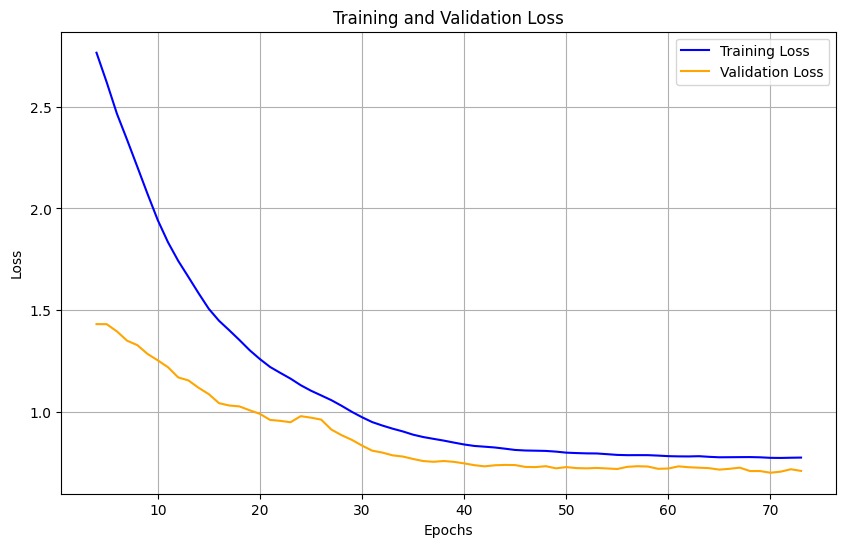

In [ ]:
import matplotlib.pyplot as plt

def curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_loss = curve(train_loss)
val_loss = curve(val_loss)

plt.figure(figsize=(10, 6))
plt.plot(range(4, len(train_loss) + 4), train_loss, label='Training Loss', color='blue')
plt.plot(range(4, len(val_loss) + 4), val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


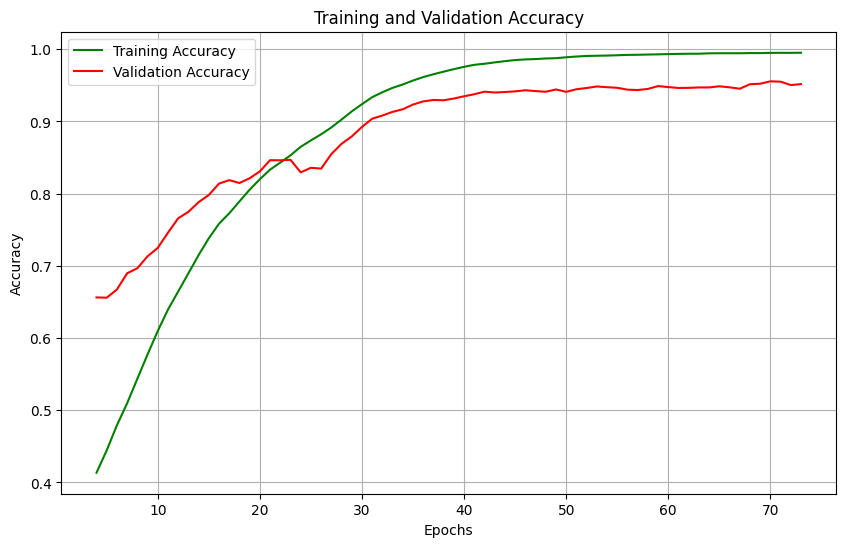

In [ ]:

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_acc = curve(train_acc)
val_acc = curve(val_acc)


plt.figure(figsize=(10, 6))
plt.plot(range(4, len(train_acc) + 4), train_acc, label='Training Accuracy', color='green')
plt.plot(range(4, len(val_acc) + 4), val_acc, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("/kaggle/working/my_finetuned_model.h5")  # HDF5 format


### **Fine-Tuning the Model with Reduced Learning Rate**

In the fine-tuning stage, the pre-trained **ResNet50 model** is modified by unfreezing only the last **50 layers**. The rest of the layers are frozen to preserve the learned features from the previous training.

Key steps in this phase:

- **Unfreeze Last Layers**: The last 50 layers are set to be trainable, allowing the model to learn more specific features for the task at hand.
- **Reduced Learning Rate**: A **lower learning rate (1e-5)** is used to fine-tune the model gradually without disrupting the already learned features.
- **Learning Rate Reduction**: The **ReduceLROnPlateau callback** is used to reduce the learning rate when the validation loss plateaus, ensuring a more refined optimization process.

The **model** is then trained for additional epochs, with gradual updates to the weights, using the fine-tuning setup.

This phase allows the model to adapt more specifically to the dataset while retaining the knowledge from the pre-trained weights.


In [ ]:

from tensorflow.keras.losses import CategoricalCrossentropy
# Unfreeze only the top N layers (ResNet50 example)
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
for layer in base_model.layers[:-60]:  # freeze all except last 50 layers
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-7)
fine_tune_lr = 1e-5  # Small learning rate for fine-tuning
optimizer = Adam(learning_rate=fine_tune_lr)

model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

# Train for more epochs
history_fine = model.fit(
    train_dataset,
    epochs=15,  # More epochs for gradual adaptation
    validation_data=val_dataset,
    steps_per_epoch=int(len(train_df) / batch_size),
    validation_steps=int(len(test_df) / batch_size),
    callbacks=[checkpoint, reduce_lr],
    # class_weight={0: 5.0, 1: 5.0, 2: 1.0, 3: 10.0, 4: 5.0, 5: 1.0, 6: 10.0}
    class_weight=class_weights
)



Epoch 1/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 151s 415ms/step - accuracy: 0.9966 - loss: 0.7414 - val_accuracy: 0.9551 - val_loss: 0.6920 - learning_rate: 1.0000e-05
Epoch 2/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 71s 386ms/step - accuracy: 0.9955 - loss: 0.7371 - val_accuracy: 0.9453 - val_loss: 0.7256 - learning_rate: 1.0000e-05
Epoch 3/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 381ms/step - accuracy: 0.9935 - loss: 0.7498 - val_accuracy: 0.9453 - val_loss: 0.7096 - learning_rate: 1.0000e-05
Epoch 4/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9943 - loss: 0.7484
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 381ms/step - accuracy: 0.9943 - loss: 0.7484 - val_accuracy: 0.9434 - val_loss: 0.7256 - learning_rate: 1.0000e-05
Epoch 5/15
171/183 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.9936 - loss: 0.7595

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


183/183 ━━━━━━━━━━━━━━━━━━━━ 85s 466ms/step - accuracy: 0.9937 - loss: 0.7590 - val_accuracy: 0.9453 - val_loss: 0.6916 - learning_rate: 3.0000e-06
Epoch 6/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 71s 390ms/step - accuracy: 0.9975 - loss: 0.7291 - val_accuracy: 0.9453 - val_loss: 0.7008 - learning_rate: 3.0000e-06
Epoch 7/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 383ms/step - accuracy: 0.9980 - loss: 0.7317 - val_accuracy: 0.9492 - val_loss: 0.7240 - learning_rate: 3.0000e-06
Epoch 8/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 380ms/step - accuracy: 0.9982 - loss: 0.7446 - val_accuracy: 0.9609 - val_loss: 0.6517 - learning_rate: 3.0000e-06
Epoch 9/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 383ms/step - accuracy: 0.9972 - loss: 0.7435 - val_accuracy: 0.9629 - val_loss: 0.6763 - learning_rate: 3.0000e-06
Epoch 10/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 65s 357ms/step - accuracy: 0.9971 - loss: 0.7501 - val_accuracy: 0.9590 - val_loss: 0.6867 - learning_rate: 3.0000e-06
Epoch 11/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step -

###**Model Evaluation: Classification Report & Metrics**

After training the model, we evaluate its performance on the test dataset using key metrics like **classification report**, **precision**, **recall**, and **accuracy** for each class. We also compute **ROC AUC scores** (weighted and macro) to assess model performance, especially for imbalanced classes. Additionally, we plot **ROC curves** for each class to visualize the trade-offs between true positive and false positive rates. These metrics provide insights into the model's ability to classify each class accurately.

26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 388ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.77      0.43      0.56        23
         bcc       0.94      0.62      0.74        26
         bkl       0.83      0.79      0.81        66
          df       0.80      0.67      0.73         6
         mel       0.68      0.68      0.68        34
          nv       0.96      0.99      0.98       663
        vasc       0.90      0.90      0.90        10

    accuracy                           0.93       828
   macro avg       0.84      0.72      0.77       828
weighted avg       0.93      0.93      0.93       828

Precision (weighted): 0.9292003163212517
Recall (weighted): 0.9323671497584541
Accuracy: 0.9323671497584541
Weighted ROC AUC: 0.9774087679860376
Macro ROC AUC: 0.9790387535909669


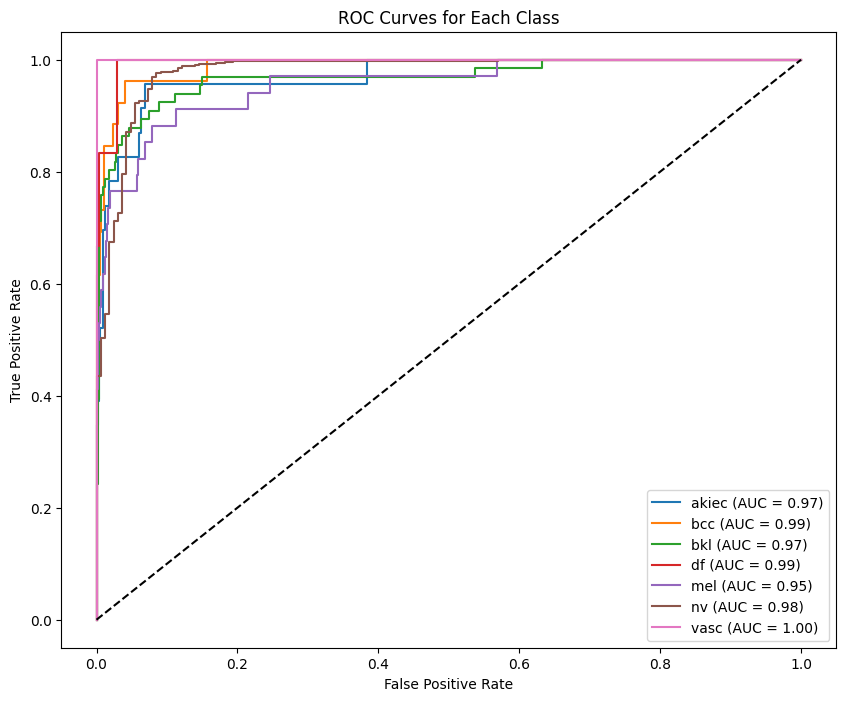

In [ ]:
# Step 7: Evaluate the model
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Classification report
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

# Precision, recall, accuracy
print("Precision (weighted):", precision_score(y_true_classes, y_pred_classes, average='weighted'))
print("Recall (weighted):", recall_score(y_true_classes, y_pred_classes, average='weighted'))
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# ROC AUC scores
y_test = tf.keras.utils.to_categorical(y_true_classes)
print("Weighted ROC AUC:", roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted'))
print("Macro ROC AUC:", roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro'))

# ROC curves for each class
fpr = {}
tpr = {}
roc_auc = {}
plt.figure(figsize=(10, 8))
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()


# **🔍 Model Evaluation & Comparison**

In this section, we evaluate the performance of the model using various metrics and compare it with the ResNet50+Soft Attention model from the paper. We will calculate overall metrics, class-wise metrics, and display a comparison table.

---

## **1. Overall Model Performance**

We calculate key performance metrics such as **accuracy**, **precision**, **recall**, **F1 score**, and **ROC AUC** scores (both weighted and macro). These metrics provide an understanding of how well the model performs overall, helping us assess its general effectiveness. The results are summarized in a table to give a clear overview of the model's performance.

---




In [ ]:
import pandas as pd

results = {
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1 Score (Weighted)', 'ROC AUC (Weighted)', 'ROC AUC (Macro)'],
    'Your Model': [
        accuracy_score(y_true_classes, y_pred_classes),
        precision_score(y_true_classes, y_pred_classes, average='weighted'),
        recall_score(y_true_classes, y_pred_classes, average='weighted'),
        (2 * precision_score(y_true_classes, y_pred_classes, average='weighted') * recall_score(y_true_classes, y_pred_classes, average='weighted')) /
        (precision_score(y_true_classes, y_pred_classes, average='weighted') + recall_score(y_true_classes, y_pred_classes, average='weighted')),
        roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted'),
        roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
    ]
}

results_df = pd.DataFrame(results)
print("\n🔍 Results Summary:")
print(results_df.to_string(index=False))



🔍 Results Summary:
              Metric  Your Model
            Accuracy    0.932367
Precision (Weighted)    0.929200
   Recall (Weighted)    0.932367
 F1 Score (Weighted)    0.930781
  ROC AUC (Weighted)    0.977409
     ROC AUC (Macro)    0.979039


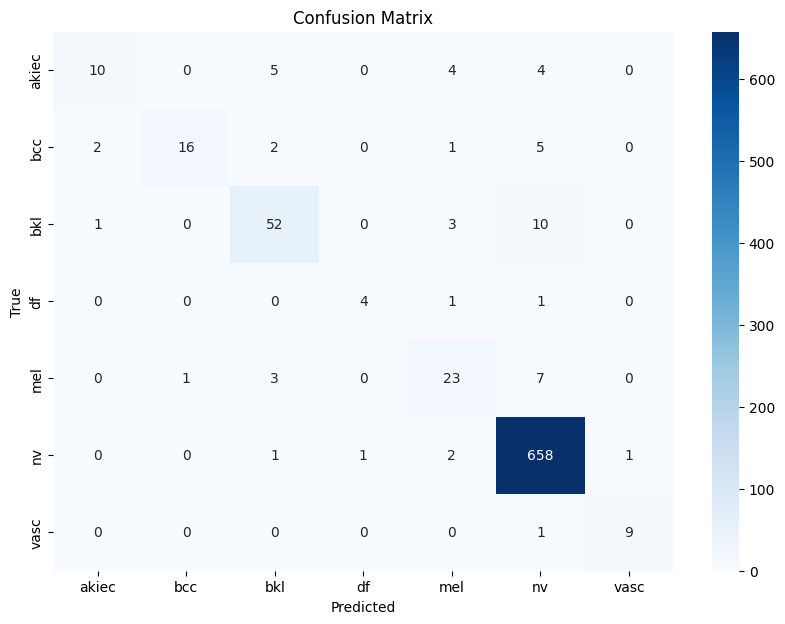

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **2. Class-wise Evaluation**

In addition to overall performance, we also evaluate the model's performance for each individual class. Metrics like **precision**, **recall**, **F1 score**, and **ROC AUC** are computed for each skin lesion class. This detailed analysis provides insights into how well the model handles each specific class, especially important for understanding the model's behavior on imbalanced classes.

---


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

class_wise_metrics = precision_recall_fscore_support(y_true_classes, y_pred_classes, average=None)

class_roc_auc = [roc_auc_score(y_test[:, i], y_pred[:, i]) for i in range(7)]

class_table = pd.DataFrame({
    'Class': target_names,
    'Precision': class_wise_metrics[0],
    'Recall': class_wise_metrics[1],
    'F1 Score': class_wise_metrics[2],
    'ROC AUC': class_roc_auc
})

print("\n📊 Class-wise Metrics:")
print(class_table.to_string(index=False))



📊 Class-wise Metrics:
Class  Precision   Recall  F1 Score  ROC AUC
akiec   0.769231 0.434783  0.555556 0.970024
  bcc   0.941176 0.615385  0.744186 0.988490
  bkl   0.825397 0.787879  0.806202 0.967351
   df   0.800000 0.666667  0.727273 0.994526
  mel   0.676471 0.676471  0.676471 0.954956
   nv   0.959184 0.992459  0.975537 0.978902
 vasc   0.900000 0.900000  0.900000 0.999022



## **3. Model vs. Paper Comparison**

Finally, we compare the performance of our model with the **ResNet50+Soft Attention (Paper)** model. This comparison shows how our model performs relative to the benchmark established in the paper. By examining this comparison, we can identify areas where our model might be excelling or where improvements could be made, helping us gauge its effectiveness in a broader context.

In [ ]:
from sklearn.metrics import precision_score, roc_auc_score, precision_recall_fscore_support

# --- Overall metrics ---
your_precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
your_auc_weighted = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
your_auc_macro = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')

# --- Class-wise precision ---
class_precisions, _, _, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average=None)

my_results = {
    "Model": "Our Model",
    "Precision": your_precision,
    "AUC": your_auc_macro,
    "Weighted Precision": your_precision,
    "Weighted AUC": your_auc_weighted,
    "AKIEC Precision": class_precisions[0],
    "BCC Precision": class_precisions[1],
    "BKL Precision": class_precisions[2],
    "DF Precision": class_precisions[3],
    "MEL Precision": class_precisions[4],
    "NV Precision": class_precisions[5],
    "VASC Precision": class_precisions[6]
}

my_results

{'Model': 'Our Model',
 'Precision': 0.9292003163212517,
 'AUC': 0.9790387535909669,
 'Weighted Precision': 0.9292003163212517,
 'Weighted AUC': 0.9774087679860376,
 'AKIEC Precision': 0.7692307692307693,
 'BCC Precision': 0.9411764705882353,
 'BKL Precision': 0.8253968253968254,
 'DF Precision': 0.8,
 'MEL Precision': 0.6764705882352942,
 'NV Precision': 0.9591836734693877,
 'VASC Precision': 0.9}

In [ ]:
import pandas as pd

paper_results = {
    "Model": "ResNet50+SA (Paper)",
    "Precision": 0.841,          # Average precision (from Table 1, HAM10000)
    "AUC": 0.980,                # Average AUC (from Table 1, HAM10000)
    "Weighted Precision": 0.910, # Weighted precision (from Table 1, HAM10000)
    "Weighted AUC": 0.978,       # Weighted AUC (from Table 1, HAM10000)
    "MEL Precision": 0.730,      # MEL class precision (from Table 1, HAM10000)
    "BKL Precision": 0.670,      # BKL class precision (from Table 1, HAM10000)
    "NV Precision": 0.950,       # NV class precision (from Table 1, HAM10000)
    "AKIEC Precision": 0.670,    # AKIEC class precision (from Table 1, HAM10000)
    "DF Precision": 1.000,       # DF class precision (from Table 1, HAM10000)
    "BCC Precision": 0.880,      # BCC class precision (from Table 1, HAM10000)
    "VASC Precision": 1.000      # VASC class precision (from Table 1, HAM10000)
}

# Create DataFrame
comparison_df = pd.DataFrame([paper_results, my_results])

# Set Model as index for better formatting
comparison_df.set_index("Model", inplace=True)

# Round values for better presentation
comparison_df = comparison_df.round(3)

# Display the table
print("📊 Comparison Between ResNet50+SA (Paper) and Your Model:")
display(comparison_df)


📊 Comparison Between ResNet50+SA (Paper) and Your Model:


,Precision,AUC,Weighted Precision,Weighted AUC,MEL Precision,BKL Precision,NV Precision,AKIEC Precision,DF Precision,BCC Precision,VASC Precision
Model,,,,,,,,,,,
ResNet50+SA (Paper),0.841,0.980,0.910,0.978,0.730,0.670,0.950,0.670,1.0,0.880,1.0
Our Model,0.929,0.979,0.929,0.977,0.676,0.825,0.959,0.769,0.8,0.941,0.9


# Visualizing Model Attention Maps

In this section, we visualize the attention maps generated by the model to understand which regions it focuses on when making predictions.

1. **Selecting Test Images**: We first select a small batch of test images from the dataset, specifically the top 3 images, for visual inspection.
   
2. **Getting Predictions and Attention Maps**: The `get_predictions_and_attention` function is used to generate both the model's predictions and the attention maps for the selected images.

3. **Visualizing Attention**: For each of the selected images, we create four different visualizations:
   - The original image.
   - The soft attention map, which highlights the regions the model focuses on.
   - The overlay of the attention map on the image to show how it influences the model’s prediction.
   - An alternative visualization of the attention map using the viridis color map.

These visualizations help us understand which parts of the image are most influential in the model’s decision-making process, giving us insights into its interpretability.



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


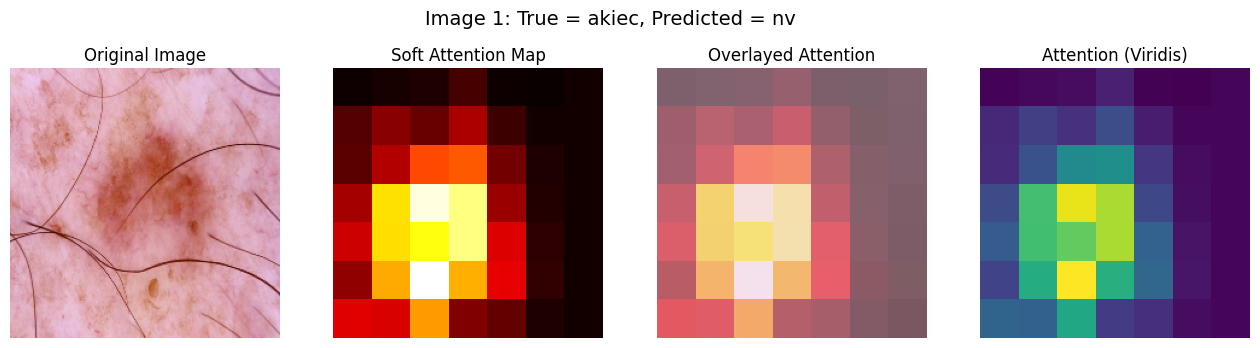

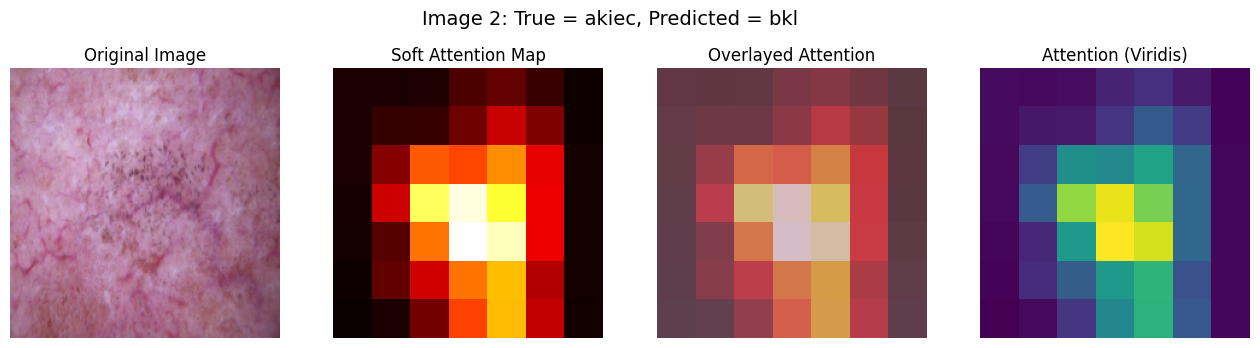

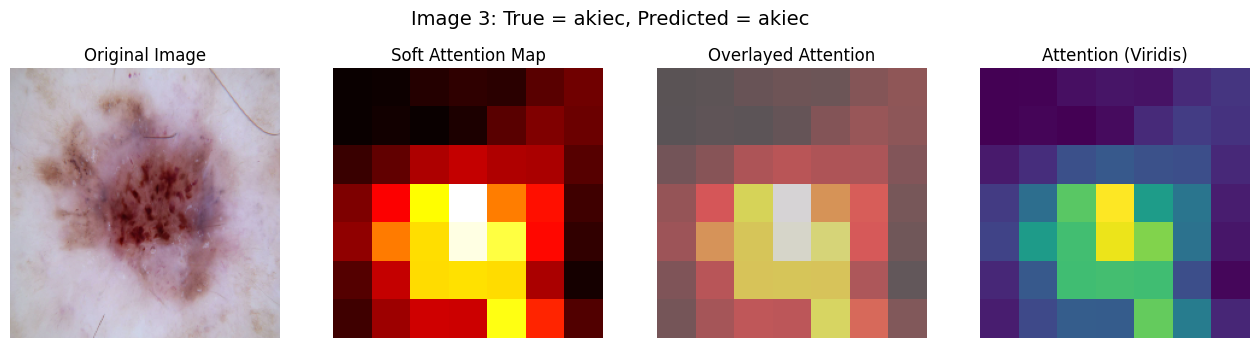

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images
sample_images, sample_labels = next(iter(test_dataset))
sample_images = sample_images[:3]  # pick top 3 images
sample_labels = sample_labels[:3]

# Get predictions and attention map from your model
def get_predictions_and_attention(model, images, attention_layer_name='soft_attention'):
    outputs = model.get_layer(attention_layer_name).output
    attention_model = tf.keras.Model(inputs=model.input, outputs=[model.output, outputs[1]])  # outputs[1] is attention map
    preds, attn_maps = attention_model.predict(images)
    return preds, attn_maps

preds, attns = get_predictions_and_attention(model, sample_images)

# Class names
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Plot function
def visualize_attention_comparison(img, true_label, pred, attn, index):
    img = img.numpy() / 255.0
    true_class = class_names[np.argmax(true_label)]
    pred_class = class_names[np.argmax(pred)]
    attn_avg = np.mean(attn[0], axis=0)  # average over heads

    plt.figure(figsize=(16, 4))
    plt.suptitle(f"Image {index+1}: True = {true_class}, Predicted = {pred_class}", fontsize=14)

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(attn_avg, cmap='hot')
    plt.title("Soft Attention Map")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(img)
    plt.imshow(attn_avg, cmap='hot', alpha=0.5)
    plt.title("Overlayed Attention")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(attn_avg, cmap='viridis')
    plt.title("Attention (Viridis)")
    plt.axis("off")

    plt.show()

# Loop over samples
for i in range(len(sample_images)):
    visualize_attention_comparison(sample_images[i], sample_labels[i], preds[i], attns[i:i+1], i)


In [ ]:
model.save("my_finetuned_model.keras")
